In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
tf.keras.utils.set_random_seed(0)

In [2]:
df = pd.read_csv("./src/data_from_good.csv", sep=";")

In [3]:
df.head()

,position d1,intensity d1,result,mesure
0,99,770,1,1
1,98,727,1,1
2,97,682,1,1
3,96,771,1,1
4,95,933,1,1


In [4]:
df['mesure'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int64)

In [5]:
X = []
y = [] 

In [6]:
for i in range(1,21):
    x_temp = df[df['mesure']==i].T.loc['intensity d1'].values
    y_temp = df[df['mesure']==i]['result'].values[0]
    X.append(x_temp)
    y.append(y_temp)

In [7]:
import numpy as np

In [8]:
X = np.array(X) 
y = np.array(y)

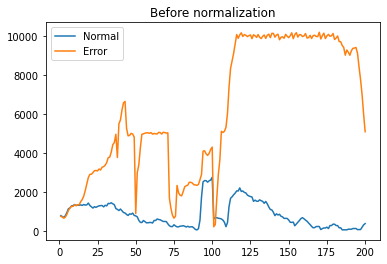

In [9]:
plt.plot(range(1,201), X[0], label='Normal')
plt.plot(range(1,201),X[-1], label='Error')
plt.title('Before normalization')
plt.legend()

In [10]:
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)

In [11]:
X = (X-mean)/std

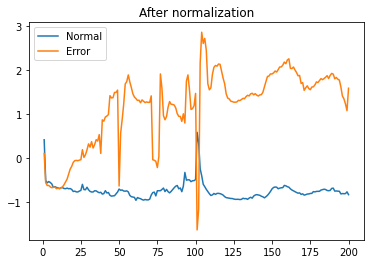

In [12]:
plt.plot(range(1,201), X[0], label='Normal')
plt.plot(range(1,201),X[-1], label='Error')
plt.title("After normalization")
plt.legend()

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, random_state=0, train_size=0.8)

## Model - Vanilla NN

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X.shape[1],)),
    tf.keras.layers.Dense(100),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss='mse')

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)

Epoch 1/10

1/1 [==============================] - 1s 825ms/step - loss: 0.0767 - val_loss: 1.7530e-07
Epoch 2/10
1/1 [==============================] - 0s 54ms/step - loss: 1.2352e-05 - val_loss: 1.7488e-07
Epoch 3/10
1/1 [==============================] - 0s 51ms/step - loss: 1.2315e-05 - val_loss: 1.7441e-07
Epoch 4/10
1/1 [==============================] - 0s 59ms/step - loss: 1.2277e-05 - val_loss: 1.7396e-07
Epoch 5/10
1/1 [==============================] - 0s 58ms/step - loss: 1.2237e-05 - val_loss: 1.7345e-07
Epoch 6/10
1/1 [==============================] - 0s 75ms/step - loss: 1.2195e-05 - val_loss: 1.7294e-07
Epoch 7/10
1/1 [==============================] - 0s 50ms/step - loss: 1.2151e-05 - val_loss: 1.7238e-07
Epoch 8/10
1/1 [==============================] - 0s 50ms/step - loss: 1.2106e-05 - val_loss: 1.7182e-07
Epoch 9/10
1/1 [==============================] - 0s 57ms/step - loss: 1.2058e-05 - val_loss: 1.7125e-07
Epoch 10/10
1/1 [==============================] - 0s 51m

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,11)

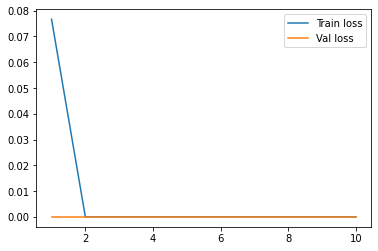

In [18]:
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Val loss')
plt.legend()

In [19]:
model.evaluate(X_val, y_val)

1/1 [==============================] - 0s 31ms/step - loss: 1.7062e-07


1.7061822177311115e-07

In [20]:
X_val.shape

(4, 200)

In [21]:
y_pred_proba = model.predict(X_val)
y_pred_proba

1/1 [==============================] - 0s 104ms/step


array([[2.1682896e-04],
       [9.9944359e-01],
       [9.1461270e-06],
       [9.9942923e-01]], dtype=float32)

In [22]:
y_pred = [0 if p < 0.5 else 1 for p in y_pred_proba] # list comprehension
y_pred

[0, 1, 0, 1]

In [23]:
y_val

array([0, 1, 0, 1], dtype=int64)

## Guardar modelo

In [24]:
tf.saved_model.save(model, 'models/data_good') # Tensorflow format ==> formato original, mayor compatibilidad.
converter = tf.lite.TFLiteConverter.from_saved_model("models/data_good")

INFO:tensorflow:Assets written to: models/data_good\assets


INFO:tensorflow:Assets written to: models/data_good\assets


In [25]:
model.save("models/data_good.keras") # Keras format ==> 

In [26]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [27]:
def representative_data_gen():
    for value in X:
        # Each scalar value must be inside of a 2D array that is wrapped in a list
        yield [np.array(value, dtype=np.float32, ndmin=2)]

In [28]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 or int8
converter.inference_input_type = tf.uint8 # can be changed to tf.int8
converter.inference_output_type = tf.uint8 # can be changed to tf.int8
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpaoavwoso\assets


INFO:tensorflow:Assets written to: C:\Users\HP\AppData\Local\Temp\tmpaoavwoso\assets
C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [30]:
# Save the model to disk
with open("models/data_good_rx_ready.tflite", "wb") as f:
    f.write(tflite_model)